<a href="https://colab.research.google.com/github/muralikrishnan2022/FACE_DETECTION_PYSPARK/blob/main/FACEDETECTION_VAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=6c86f39a8c6e66b9ce7a1f321620b8d76aa8822751f0f90119c8eb3a1da3875e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import cv2
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import os

In [ ]:
# Initialize a Spark session
spark = SparkSession.builder.appName("HaarCascadeObjectDetection").getOrCreate()

In [ ]:
# Define a UDF (User-Defined Function) for face detection
def detect_faces(image_path):
    # Load the Haar Cascade classifier for face detection
    face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_alt.xml')

    # Read the input image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Counter for detected faces
    face_count = 0

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

    # Draw rectangles around detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        face_count += 1

        # Break the loop if 5 faces are detected
        if face_count == 5:
            break


   # Save the image with detected faces (optional)
    output_image_path = os.path.splitext(image_path)[0] +'/content/output_image.jpg'
    cv2.imwrite(output_image_path, image)

    return output_image_path

In [ ]:
 # Register the UDF
detect_faces_udf = udf(detect_faces, StringType())

# Apply the face detection UDF to a DataFrame with image paths
input_data = ['/content/people_img.jpg']  # Replace with your image paths
df = spark.createDataFrame(input_data, StringType())

result_df = df.withColumn("/content/output_image", detect_faces_udf(df["value"]))

# Show the results
result_df.show(truncate=False)

# Display the output image
output_image_path = result_df.select("/content/output_image").collect()[0][0]
output_image = cv2.imread(output_image_path)


+-----------------------+--------------------------------------------+
|value                  |/content/output_image                       |
+-----------------------+--------------------------------------------+
|/content/people_img.jpg|/content/people_img/content/output_image.jpg|
+-----------------------+--------------------------------------------+



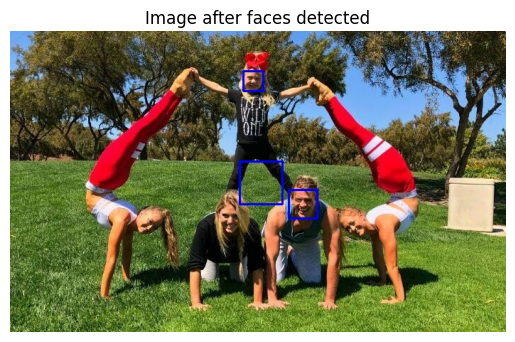

In [ ]:
# Read the image using OpenCV
image_path = "/content/people_img.jpg"
image = cv2.imread(image_path)

# Display the image with Matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title('Image after faces detected')
plt.axis('off')
plt.show()

# Stop the Spark session
spark.stop()